In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

# Simulated single PPO iteration on 1D actions for a single state

In [445]:
def plot_adv(ax, adv_fn):
    x_samples = np.linspace(-3, 3, 128)
    sns.lineplot(x=x_samples, y=np.vectorize(adv_fn)(x_samples), ax=ax, label='Advantage')
    ax.set_xlabel('Action')
    ax.set_ylabel('Advantage (simulated)')
    #ax.lines[0].set_linestyle("--")

In [554]:
def plot_mw(policy, eta, ax, adv_fn):
    x_samples = policy.sample(policy(), 1024)
    ll = policy.get_log_likelihood(policy(), x_samples).detach().numpy()
    advs = np.vectorize(adv_fn)(x_samples)
    advs = adv_normalize(torch.Tensor(advs)).detach().numpy()
    partition_fn = np.mean(np.exp(eta * advs))
    pdf_mw = np.exp(ll + eta * advs - np.log(partition_fn))
    sns.lineplot(x=x_samples, y=pdf_mw, ax=ax, label='Multiplicative Weights Update')
    ax.set_xlabel('Action')
    ax.set_ylabel('PDF')
    ax.lines[-1].set_linestyle("--")

In [570]:
import torch
from torch import nn

def adv_normalize(adv):
    std = adv.std()

    assert std != 0. and not torch.isnan(std), 'Need nonzero std'
    n_advs = (adv - adv.mean())/(adv.std()+1e-8)
    return n_advs

def surrogate_reward(adv, *, new, old, clip_eps=None, clip_adv=None):
    '''
    Computes the surrogate reward for TRPO and PPO:
    R(\theta) = E[r_t * A_t]
    with support for clamping the ratio (for PPO) and normalized adv, s.t.
    R(\theta) = E[clamp(r_t, 1-e, 1+e) * clamp(A_t, -a, a)]
    Inputs:
    - adv, unnormalized advantages as calculated by the agents
    - log_ps_new, the log probabilities assigned to taken events by \theta_{new}
    - log_ps_old, the log probabilities assigned to taken events by \theta_{old}
    - clip_EPS, the clipping boundary for PPO loss
    - clip_adv, the clipping bondary for normalized advantages
    Returns:
    - The surrogate loss as described above
    '''
    log_ps_new, log_ps_old = new, old

    # Normalized Advantages
    n_advs = adv_normalize(adv)

    # Clip advantages
    if clip_adv is not None:
        n_advs = torch.clamp(n_advs, -clip_adv, clip_adv)

    # Ratio of new probabilities to old ones
    ratio_new_old = torch.exp(log_ps_new - log_ps_old)

    # Clamping (for use with PPO)
    if clip_eps is not None:
        ratio_new_old = torch.clamp(ratio_new_old, 1-clip_eps, 1+clip_eps)
    return ratio_new_old * n_advs

class GaussianPolicy(nn.Module):
    def __init__(self, init_mean=0, init_stdev=1):
        super(GaussianPolicy, self).__init__()
        self.mean = nn.Parameter(torch.Tensor([init_mean]))
        self.log_stdev = nn.Parameter(torch.Tensor(np.log([init_stdev])))
        
    def forward(self):
        return self.mean, torch.exp(self.log_stdev)
        
    def sample(self, p, n_samples):
        mean, std = p
        return (mean + torch.randn(n_samples)*std).detach()
    
    def get_log_likelihood(self, p, actions):
        mean, std = p
        nll =  0.5 * (((actions - mean)/std).pow(2)) \
                   + 0.5 * np.log(2.0 * np.pi) \
                   + self.log_stdev
        return -nll
    
    def calc_kl(self, p, q):
        '''
        Get the expected KL distance between two sets of gaussians over states -
        gaussians p and q where p and q are each tuples (mean, var)
        - In other words calculates E KL(p||q): E[sum p(x) log(p(x)/q(x))]
        - From https://stats.stackexchange.com/a/60699
        '''
        p_mean, p_std = p
        q_mean, q_std = q
        p_var = p_std * p_std
        q_var = q_std * q_std

        d = 1
        logdetp = torch.log(p_var)
        logdetq = torch.log(q_var)
        diff = q_mean - p_mean

        log_quot_frac = logdetq - logdetp
        tr = p_var / q_var
        quadratic = diff / q_var * diff

        kl_sum = 0.5 * (log_quot_frac - d + tr + quadratic)
        return kl_sum.mean()
    
    def plot(self, label, ax, show_clip_interval=False, color=None):
        x_samples = np.linspace(-3, 3, 100)
        mean, std = self()
        pdf_samples = norm.pdf(x_samples, mean.detach(), std.detach())
        sns.lineplot(x_samples, pdf_samples,
                     ax=ax, label=label, color=color)
        if show_clip_interval:
            ax.fill_between(x_samples, 0.8 * pdf_samples, 1.2 * pdf_samples,
                            facecolor=color, alpha=0.3)
        ax.set_xlabel('Action')
        ax.set_ylabel('PDF')

def ppo_step(policy, params, adv_fn, ax=None):
    if ax is None:
        ax = plt.axes()
    opt = torch.optim.Adam(policy.parameters(), lr=params['lr'], eps=params['adam_eps'])
    old_policy = tuple(x.detach() for x in policy())
    color_palette = sns.cubehelix_palette(int(params['num_gradient_steps']/params['plot_every']) + 1)
    for i in range(params['num_gradient_steps']):
        batch_actions = policy.sample(old_policy, params['batch_size']).detach()
        batch_advs = torch.Tensor(np.vectorize(adv_fn)(batch_actions))
        batch_old_log_ps = policy.get_log_likelihood(old_policy, batch_actions)
        policy_dist = policy()
        new_log_ps = policy.get_log_likelihood(policy_dist, batch_actions)

        if params['mode'] == 'ppo':
            # Calculate rewards
            unclp_rew = surrogate_reward(batch_advs, new=new_log_ps,
                    old=batch_old_log_ps, clip_adv=params['clip_advantages'])
            clp_rew = surrogate_reward(batch_advs, new=new_log_ps,
                    old=batch_old_log_ps, clip_eps=params['clip_eps'],
                    clip_adv=params['clip_advantages'])
            surrogate = -torch.min(unclp_rew, clp_rew).mean()
            #print(surrogate)

            # KL penalty new to old
            kl_penalty = policy.calc_kl(policy_dist, old_policy) * params['kl_penalty_coeff']
            #print(kl_penalty)

            # Total loss
            loss = surrogate + kl_penalty
        if params['mode'] == 'mw':
            eta = 1.0 / params['kl_penalty_coeff']
            batch_advs_n = adv_normalize(batch_advs)
            partition_fn = torch.mean(torch.exp(eta * batch_advs_n))
            target_log_ps = (batch_old_log_ps + eta * batch_advs_n - torch.log(partition_fn)).detach()
            ratio_new_old = torch.exp(new_log_ps - batch_old_log_ps)
            ratio_new_old = torch.clamp(ratio_new_old, 1-params['clip_eps'], 1+params['clip_eps'])
            loss = torch.mean(ratio_new_old * (new_log_ps - target_log_ps))
            #loss = torch.nn.MSELoss()(new_log_ps, target_log_ps)
        if params['mode'] == 'mw_reverse':
            eta = 1.0 / params['kl_penalty_coeff']
            batch_advs_n = adv_normalize(batch_advs)
            loss = torch.mean(new_log_ps * torch.exp(eta * batch_advs_n))    
            
        # Adam optimizer step
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i > 0 and i%params['plot_every'] == 0:
            color = color_palette[int(i/params['plot_every'])]
            policy.plot("Step %d" % i, ax, color=color)
            print("Step %d: " % i, loss)

    return loss

In [571]:
base_params = {
    'num_gradient_steps': 1001,
    'batch_size': 128,
    'clip_advantages': 1e8,
    'clip_eps': 1e8,
    'kl_penalty_coeff': 0.0,
    'lr': 3e-4,
    'adam_eps': 1e-5,
    'plot_every': 200,
    'mode': 'ppo',
}
pg_params = base_params
ppo_clip_params = base_params.copy()
ppo_clip_params['clip_eps'] = 0.2
ppo_kl_params = base_params.copy()
ppo_kl_params['kl_penalty_coeff'] = 3.0
ppo_kl_clip_params = base_params.copy()
ppo_kl_clip_params['kl_penalty_coeff'] = 3.0
ppo_kl_clip_params['clip_eps'] = 0.2
mw_params = base_params.copy()
mw_params['mode'] = 'mw'
mw_params['kl_penalty_coeff'] = 3.0
mw_params['clip_eps'] = 0.2
mw_reverse_params = mw_params.copy()
mw_reverse_params['mode'] = 'mw_reverse'
methods = {
    'Vanilla Policy Gradient': pg_params,
    'PPO, clipped surrogate': ppo_clip_params,
    'PPO, KL penalty': ppo_kl_params,
    'PPO, clipped surrogate + KL penalty': ppo_kl_clip_params,
    'MW': mw_params,
    'MW, reverse': mw_reverse_params,
}

In [503]:
# A uni-modal advantage function
from scipy.stats import norm
def adv_fn_unimodal(x):
    return 0.7 * norm.pdf(x, loc=2.0, scale=1.0) + 0.3 * norm.pdf(x, loc=-0.4, scale=0.7)

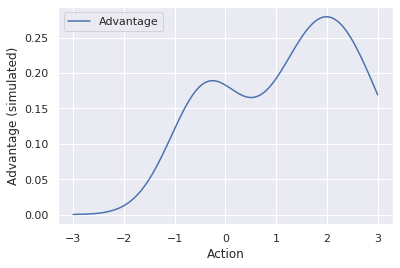

In [504]:
ax = plt.axes()
plot_adv(ax, adv_fn_unimodal)
plt.show()

Step 200:  tensor(-1.4161, grad_fn=<MeanBackward0>)
Step 400:  tensor(-1.4749, grad_fn=<MeanBackward0>)
Step 600:  tensor(-1.4948, grad_fn=<MeanBackward0>)
Step 800:  tensor(-1.5143, grad_fn=<MeanBackward0>)
Step 1000:  tensor(-1.6102, grad_fn=<MeanBackward0>)


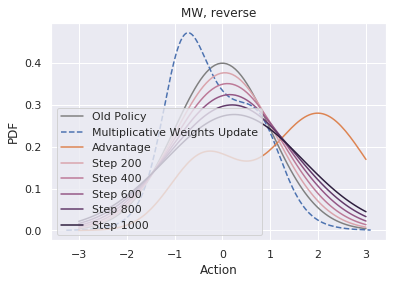

In [572]:
ax = plt.axes()
name = 'MW, reverse'
params = methods[name]
ax.set_title(name)
policy = GaussianPolicy(init_mean=0, init_stdev=1) 
policy.plot('Old Policy', ax, show_clip_interval=False, color='gray')
plot_mw(policy, 1.0/ppo_kl_params['kl_penalty_coeff'], ax, adv_fn_bimodal)
plot_adv(ax, adv_fn_unimodal)
ppo_step(policy, params, adv_fn_bimodal, ax=ax)
plt.show()

Step 200:  tensor(-0.0121, grad_fn=<AddBackward0>)
Step 400:  tensor(-0.0183, grad_fn=<AddBackward0>)
Step 600:  tensor(-0.0077, grad_fn=<AddBackward0>)
Step 800:  tensor(-0.0597, grad_fn=<AddBackward0>)
Step 1000:  tensor(-0.0434, grad_fn=<AddBackward0>)
Step 200:  tensor(-0.0171, grad_fn=<AddBackward0>)
Step 400:  tensor(-0.0081, grad_fn=<AddBackward0>)
Step 600:  tensor(-0.0067, grad_fn=<AddBackward0>)
Step 800:  tensor(-0.0088, grad_fn=<AddBackward0>)
Step 1000:  tensor(-0.0036, grad_fn=<AddBackward0>)
Step 200:  tensor(0.0124, grad_fn=<AddBackward0>)
Step 400:  tensor(0.0069, grad_fn=<AddBackward0>)
Step 600:  tensor(-0.0195, grad_fn=<AddBackward0>)
Step 800:  tensor(-0.0273, grad_fn=<AddBackward0>)
Step 1000:  tensor(-0.0051, grad_fn=<AddBackward0>)
Step 200:  tensor(-0.0073, grad_fn=<AddBackward0>)
Step 400:  tensor(-0.0057, grad_fn=<AddBackward0>)
Step 600:  tensor(-0.0018, grad_fn=<AddBackward0>)
Step 800:  tensor(-0.0131, grad_fn=<AddBackward0>)
Step 1000:  tensor(-0.0032, gr

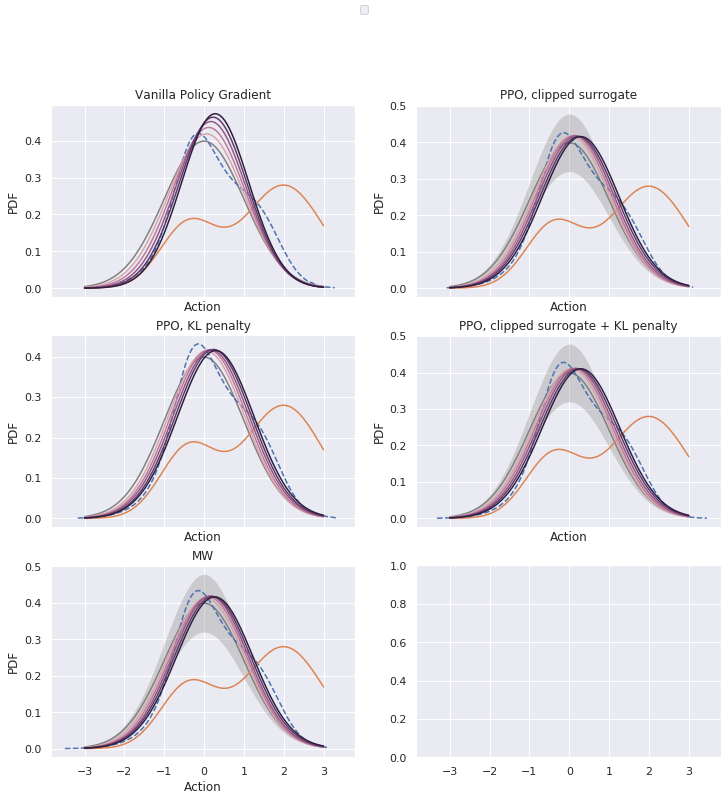

In [568]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=False)
ax_idx = 0
for name, params in methods.items():
    ax = axes.flatten()[ax_idx]
    ax.set_title(name)
    ax_idx += 1
    policy = GaussianPolicy(init_mean=0, init_stdev=1) 
    policy.plot('Old Policy', ax, show_clip_interval=(params['clip_eps'] < 1), color='gray')
    plot_mw(policy, 1.0/ppo_kl_params['kl_penalty_coeff'], ax, adv_fn_unimodal)
    plot_adv(ax, adv_fn_unimodal)
    ppo_step(policy, params, adv_fn_unimodal, ax=ax)
    ax.get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5)
plt.show()

0.28511664


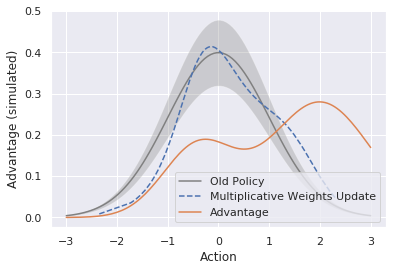

In [507]:
ax = plt.axes()
policy = GaussianPolicy(init_mean=0, init_stdev=1) 
policy.plot('Old Policy', ax, show_clip_interval=(params['clip_eps'] < 1), color='gray')
plot_mw(policy, 1.0/ppo_kl_params['kl_penalty_coeff'], ax, adv_fn_unimodal)
plot_adv(ax, adv_fn_unimodal)
plt.show()

In [467]:
# A bi-modal advantage function
from scipy.stats import norm
def adv_fn_bimodal(x):
    return 0.6 * norm.pdf(x, loc=-1, scale=0.7) + 0.4 * norm.pdf(x, loc=1, scale=0.7)

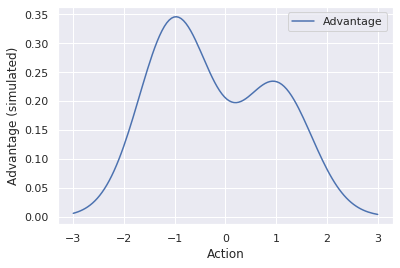

In [468]:
ax = plt.axes()
plot_adv(ax, adv_fn_bimodal)
plt.show()

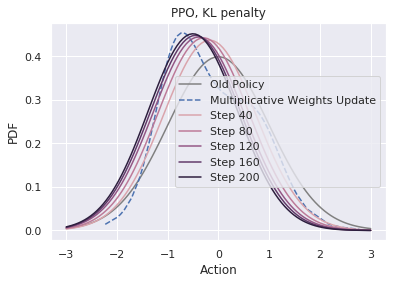

In [469]:
ax = plt.axes()
name = 'PPO, KL penalty'
params = methods[name]
ax.set_title(name)
policy = GaussianPolicy(init_mean=0, init_stdev=1) 
policy.plot('Old Policy', ax, show_clip_interval=False, color='gray')
plot_mw(policy, 1.0/ppo_kl_params['kl_penalty_coeff'], ax, adv_fn_bimodal)
ppo_step(policy, params, adv_fn_bimodal, ax=ax)
plt.show()

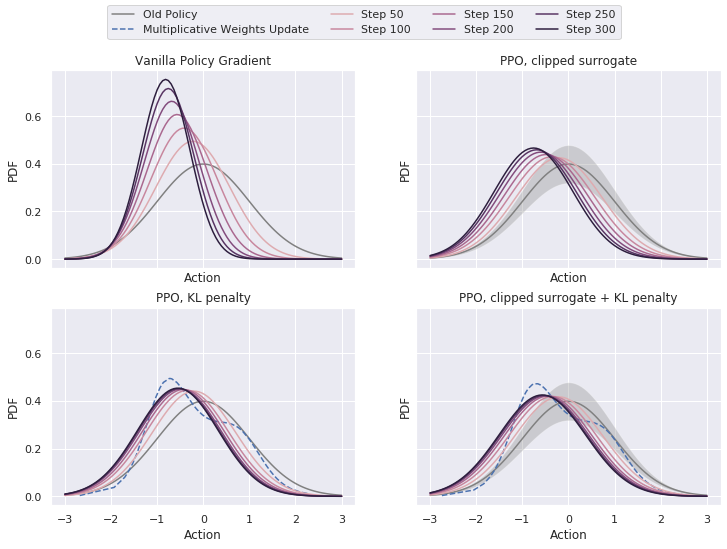

In [473]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
ax_idx = 0
for name, params in methods.items():
    ax = axes.flatten()[ax_idx]
    ax.set_title(name)
    ax_idx += 1
    policy = GaussianPolicy(init_mean=0, init_stdev=1) 
    policy.plot('Old Policy', ax, show_clip_interval=(params['clip_eps'] < 1), color='gray')
    if params['kl_penalty_coeff'] > 0:
        plot_mw(policy, 1.0/ppo_kl_params['kl_penalty_coeff'], ax, adv_fn_bimodal)
    ppo_step(policy, params, adv_fn_bimodal, ax=ax)
    ax.get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
plt.show()

In [549]:
base_params = {
    'num_gradient_steps': 301,
    'batch_size': 128,
    'clip_advantages': 1e8,
    'clip_eps': 1e8,
    'kl_penalty_coeff': 0.0,
    'lr': 1e-2,
    'adam_eps': 1e-5,
    'plot_every': 60,
    'mode': 'ppo',
}
pg_params = base_params
ppo_clip_params = base_params.copy()
ppo_clip_params['clip_eps'] = 0.2
ppo_kl_params = base_params.copy()
ppo_kl_params['kl_penalty_coeff'] = 3.0
ppo_kl_clip_params = base_params.copy()
ppo_kl_clip_params['kl_penalty_coeff'] = 3.0
ppo_kl_clip_params['clip_eps'] = 0.2
mw_params = base_params.copy()
mw_params['mode'] = 'mw'
mw_params['kl_penalty_coeff'] = 3.0
methods = {
    'Vanilla Policy Gradient': pg_params,
    'PPO, clipped surrogate': ppo_clip_params,
    'PPO, KL penalty': ppo_kl_params,
    'PPO, clipped surrogate + KL penalty': ppo_kl_clip_params,
    #'MW': mw_params,
}

Step 200:  tensor(-0.0100, grad_fn=<AddBackward0>)
Step 400:  tensor(-0.0625, grad_fn=<AddBackward0>)
Step 600:  tensor(-0.0500, grad_fn=<AddBackward0>)
Step 800:  tensor(-0.0387, grad_fn=<AddBackward0>)
Step 1000:  tensor(-0.0157, grad_fn=<AddBackward0>)
Step 200:  tensor(-0.0036, grad_fn=<AddBackward0>)
Step 400:  tensor(-0.0254, grad_fn=<AddBackward0>)
Step 600:  tensor(-0.0204, grad_fn=<AddBackward0>)
Step 800:  tensor(-0.0191, grad_fn=<AddBackward0>)
Step 1000:  tensor(-0.0008, grad_fn=<AddBackward0>)
Step 200:  tensor(-0.0166, grad_fn=<AddBackward0>)
Step 400:  tensor(-0.0149, grad_fn=<AddBackward0>)
Step 600:  tensor(-0.0097, grad_fn=<AddBackward0>)
Step 800:  tensor(-0.0089, grad_fn=<AddBackward0>)
Step 1000:  tensor(-0.0026, grad_fn=<AddBackward0>)
Step 200:  tensor(-0.0179, grad_fn=<AddBackward0>)
Step 400:  tensor(-0.0126, grad_fn=<AddBackward0>)
Step 600:  tensor(-0.0178, grad_fn=<AddBackward0>)
Step 800:  tensor(-0.0058, grad_fn=<AddBackward0>)
Step 1000:  tensor(-2.9301e-

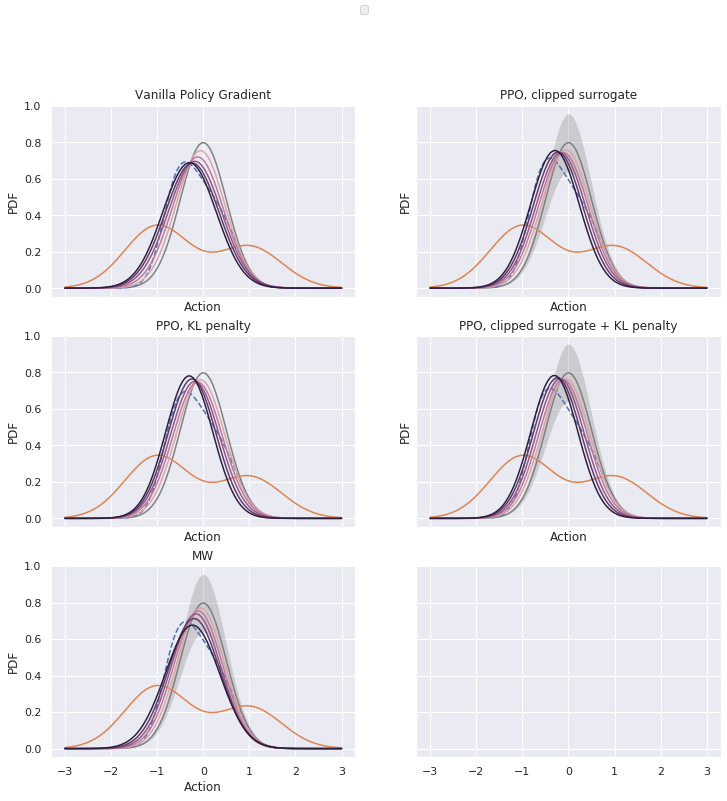

In [569]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)
ax_idx = 0
for name, params in methods.items():
    ax = axes.flatten()[ax_idx]
    ax.set_title(name)
    ax_idx += 1
    policy = GaussianPolicy(init_mean=0, init_stdev=0.5) 
    policy.plot('Old Policy', ax, show_clip_interval=(params['clip_eps'] < 1), color='gray')
    #if params['kl_penalty_coeff'] > 0:
    plot_mw(policy, 1.0/ppo_kl_params['kl_penalty_coeff'], ax, adv_fn_bimodal)
    plot_adv(ax, adv_fn_bimodal)
    ppo_step(policy, params, adv_fn_bimodal, ax=ax)
    ax.get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
plt.show()